<a href="https://colab.research.google.com/github/viswakimi/PowerPulse/blob/main/PowerPulse_Household_Energy_Usage_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PowerPulse: Household Energy Usage Forecast**

# Data Understanding and Exploration:

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")

## Load Dataset

In [51]:
file_path = "/content/drive/MyDrive/guvii/projects dataset/household_power_consumption.txt"
data = pd.read_csv(file_path, sep=';', low_memory=False,na_values=["?"], parse_dates={"datetime": ["Date", "Time"]}, infer_datetime_format=True)

# Exploratory Data Analysis (EDA)

In [52]:
data.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [54]:
data.shape

(2075259, 8)

In [55]:
data.isnull().sum()

,0
datetime,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


# Handle missing values

In [56]:
missing_data = data[data.isnull().any(axis=1)]
print(missing_data)


                   datetime  Global_active_power  Global_reactive_power  \
6839    2006-12-21 11:23:00                  NaN                    NaN   
6840    2006-12-21 11:24:00                  NaN                    NaN   
19724   2006-12-30 10:08:00                  NaN                    NaN   
19725   2006-12-30 10:09:00                  NaN                    NaN   
41832   2007-01-14 18:36:00                  NaN                    NaN   
...                     ...                  ...                    ...   
1990185 2010-09-28 19:09:00                  NaN                    NaN   
1990186 2010-09-28 19:10:00                  NaN                    NaN   
1990187 2010-09-28 19:11:00                  NaN                    NaN   
1990188 2010-09-28 19:12:00                  NaN                    NaN   
2027411 2010-10-24 15:35:00                  NaN                    NaN   

         Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  \
6839         NaN             

In [57]:
# Forward fill for continuous time-series gaps
data.fillna(method='ffill', inplace=True)

In [58]:
data.isnull().sum()

,0
datetime,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


In [59]:
data.describe()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,2008-12-06 07:12:59.999994112,1.086168e+00,1.233280e-01,2.408416e+02,4.604226e+00,1.110995e+00,1.287958e+00,6.416570e+00
min,2006-12-16 17:24:00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2007-12-12 00:18:30,3.080000e-01,4.800000e-02,2.390000e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2008-12-06 07:13:00,5.980000e-01,1.000000e-01,2.410200e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,2009-12-01 14:07:30,1.524000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,2010-11-26 21:02:00,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01
std,NaN,1.053172e+00,1.125144e-01,3.235574e+00,4.426775e+00,6.115908e+00,5.786865e+00,8.419505e+00


In [60]:
df=data

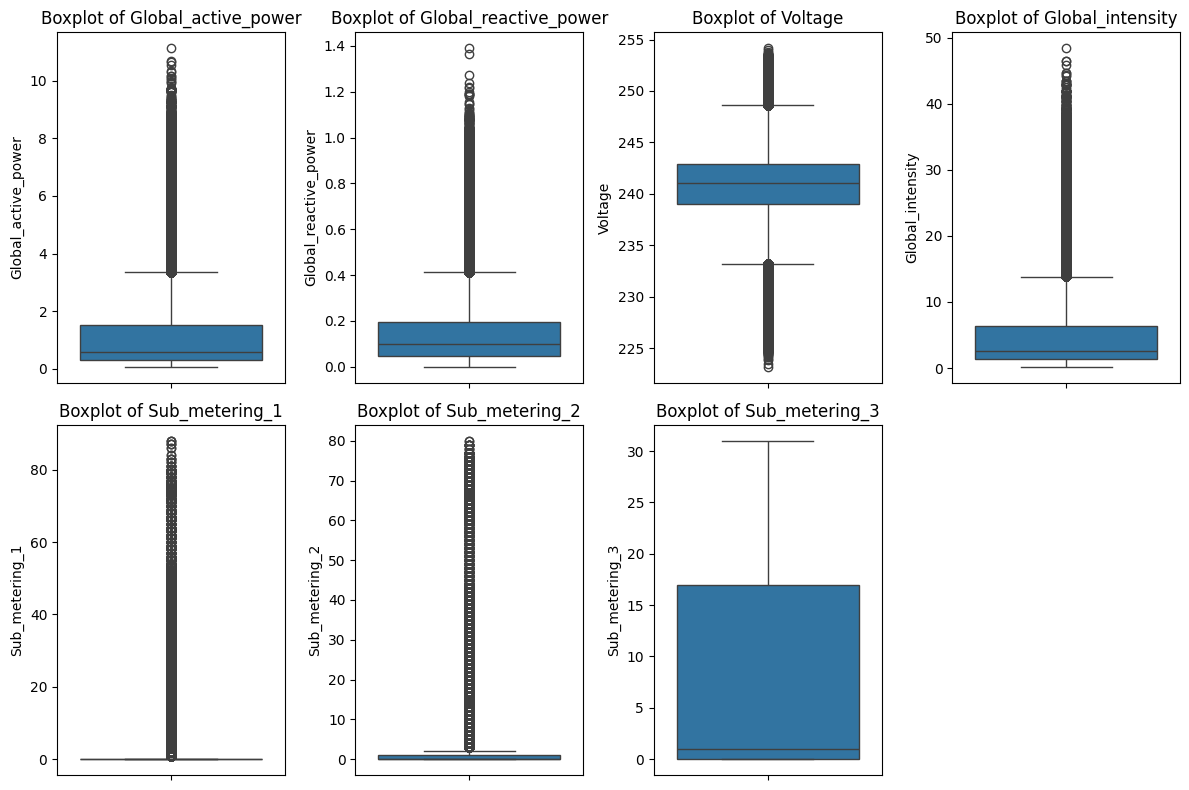

In [61]:
numeric_columns = df.select_dtypes(include=['number']).columns
# Boxplot for each numerical feature
plt.figure(figsize=(12,8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 4, i)  # Create a subplot for each variable
    sns.boxplot(data[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()


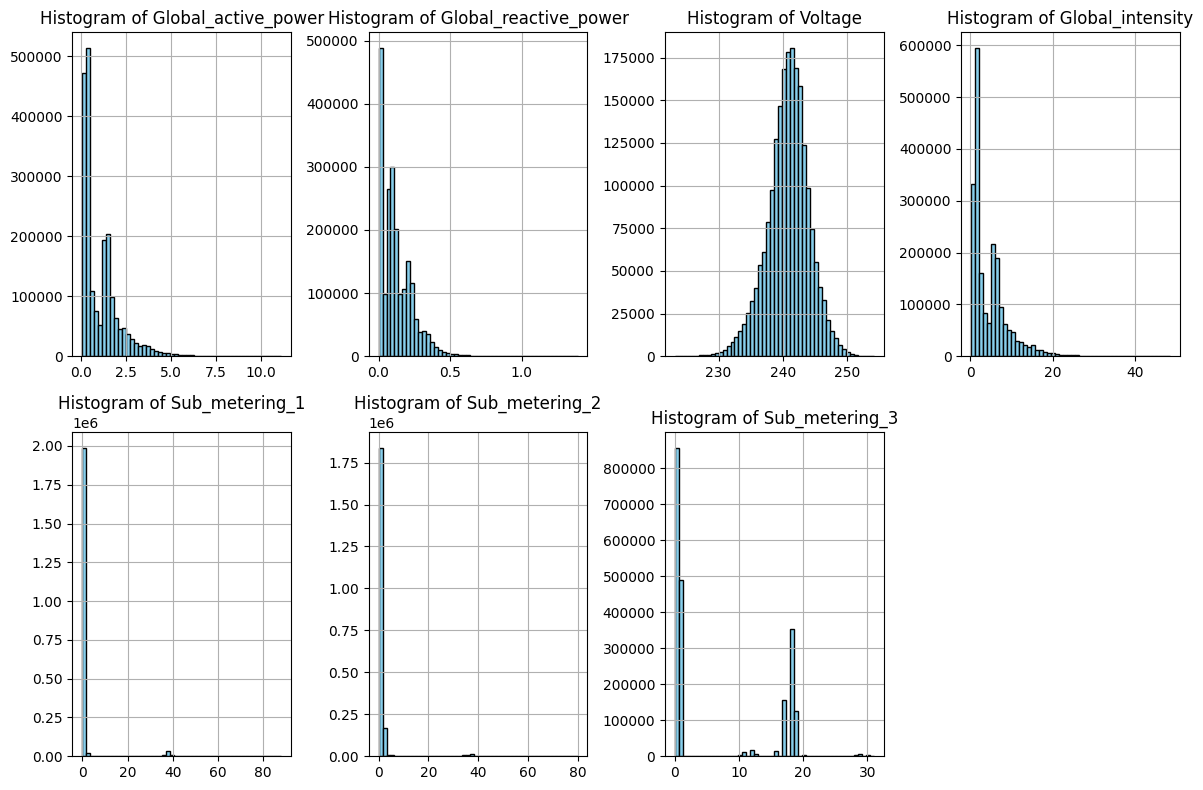

In [62]:
numeric_columns = df.select_dtypes(include=['number']).columns
plt.figure(figsize=(12, 8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 4, i)  # Create a subplot for each variable
    data[column].hist(bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
plt.tight_layout()
plt.show()

In [63]:
df.select_dtypes(include=['number']).skew()

,0
Global_active_power,1.797454
Global_reactive_power,1.265232
Voltage,-0.323726
Global_intensity,1.860937
Sub_metering_1,5.983578
Sub_metering_2,7.135711
Sub_metering_3,0.736887


# Feature Engineering: Extract date-time features

In [64]:
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["hour"] = df["datetime"].dt.hour
df["weekday"] = df["datetime"].dt.weekday
df["weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)

# Additional feature engineering

In [65]:
df["daily_avg_power"] = df.groupby(df["datetime"].dt.date)["Global_active_power"].transform("mean")
df["peak_hour"] = df["hour"].apply(lambda x: 1 if 17 <= x <= 21 else 0)
df["rolling_avg_power"] = df["Global_active_power"].rolling(window=60, min_periods=1).mean()

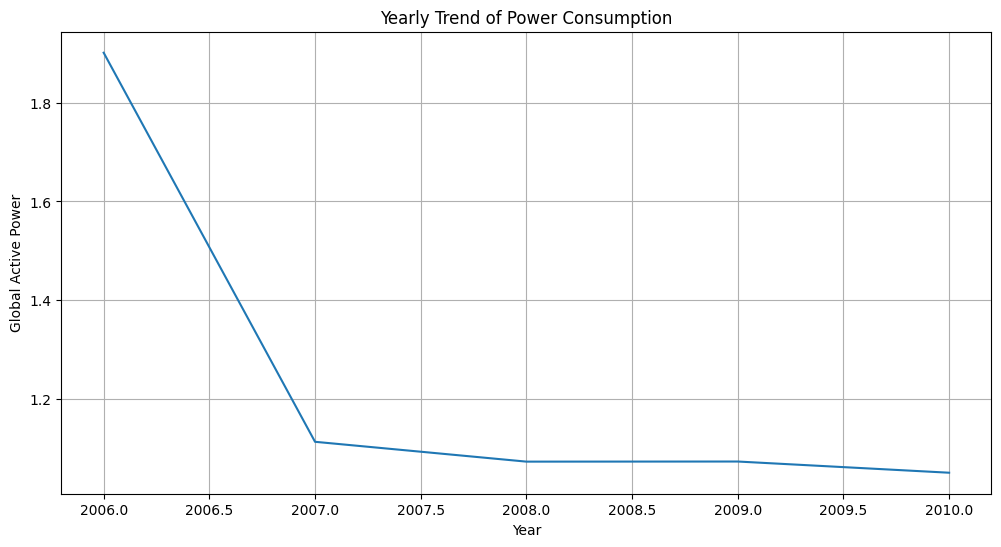

In [66]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='year', y='Global_active_power', estimator='mean', ci=None)
plt.title("Yearly Trend of Power Consumption")
plt.xlabel("Year")
plt.ylabel("Global Active Power")
plt.grid()
plt.show()

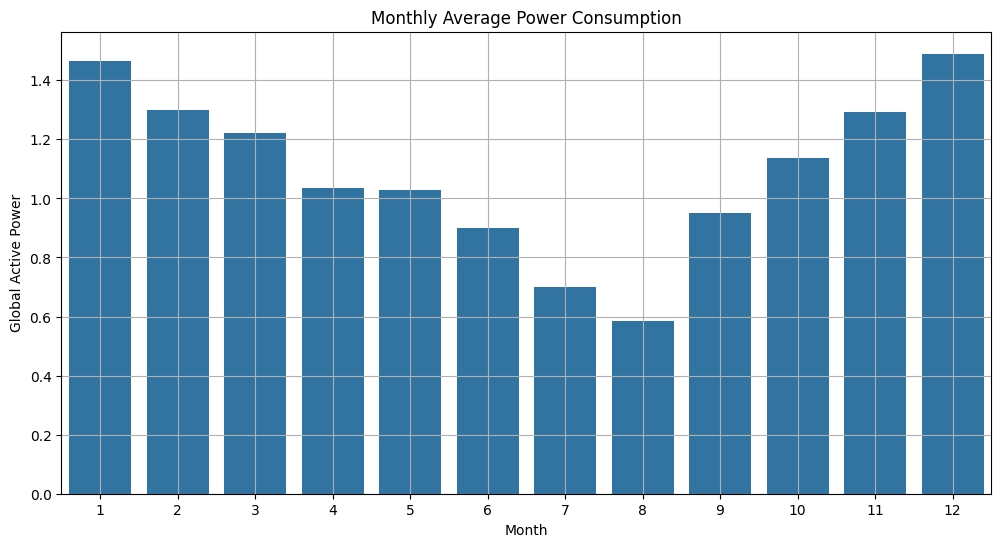

In [67]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='month', y='Global_active_power', estimator='mean', ci=None)
plt.title("Monthly Average Power Consumption")
plt.xlabel("Month")
plt.ylabel("Global Active Power")
plt.grid()
plt.show()

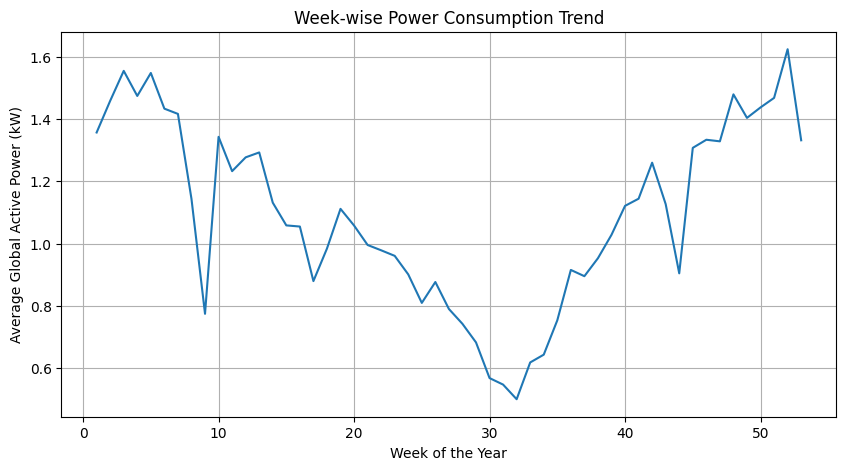

In [68]:
weekly_trend = df.groupby(df["datetime"].dt.isocalendar().week)["Global_active_power"].mean()
plt.figure(figsize=(10, 5))
weekly_trend.plot(kind="line", title="Week-wise Power Consumption Trend")
plt.xlabel("Week of the Year")
plt.ylabel("Average Global Active Power (kW)")
plt.grid()
plt.show()

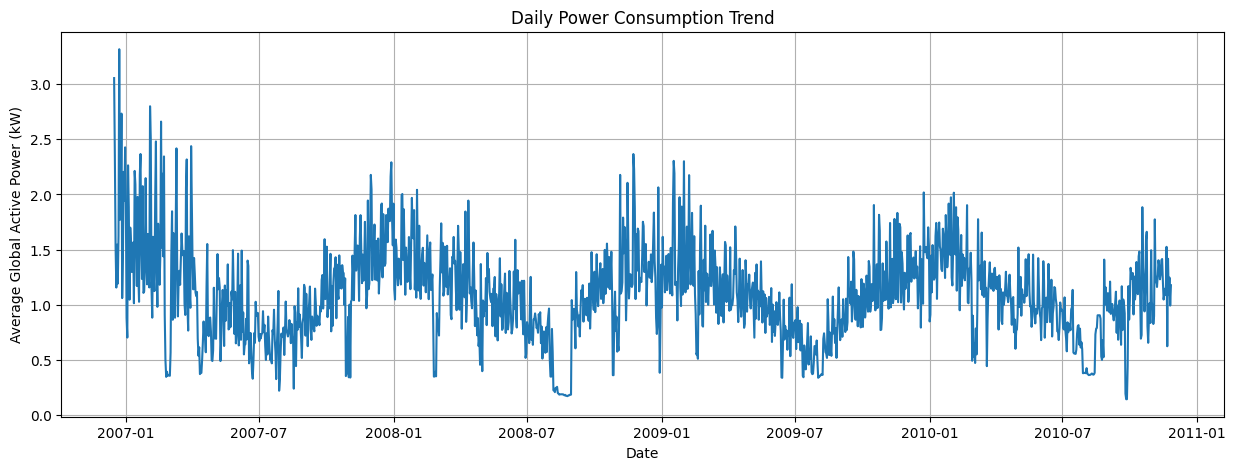

In [69]:
daily_trend = df.groupby(df["datetime"].dt.date)["Global_active_power"].mean()
plt.figure(figsize=(15, 5))
daily_trend.plot(kind="line", title="Daily Power Consumption Trend")
plt.xlabel("Date")
plt.ylabel("Average Global Active Power (kW)")
plt.grid()
plt.show()

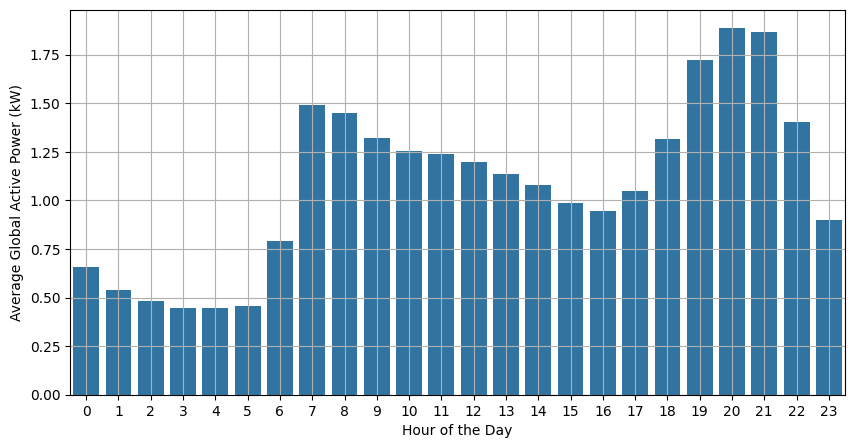

In [70]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='hour', y='Global_active_power', estimator='mean', ci=None)
plt.xlabel("Hour of the Day")
plt.ylabel("Average Global Active Power (kW)")
plt.grid()
plt.show()

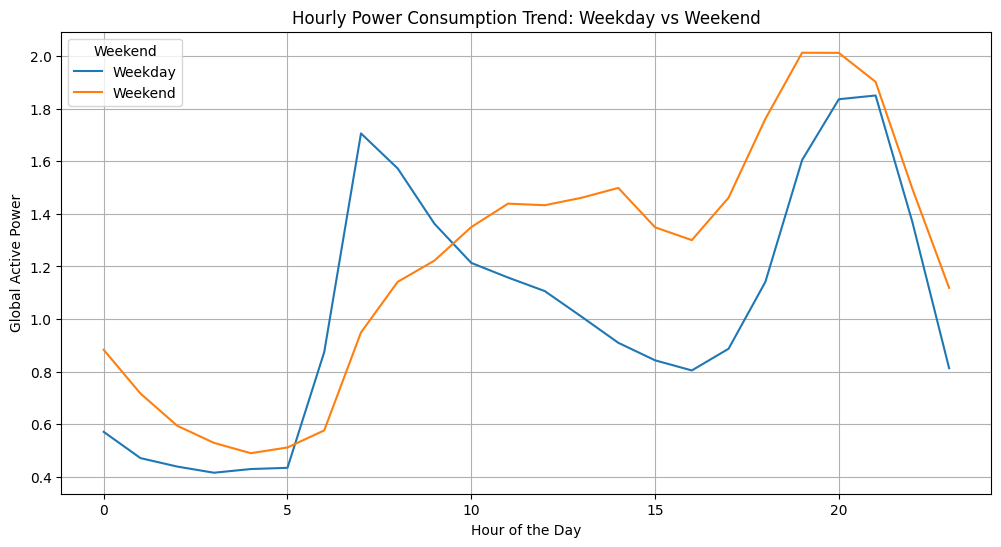

In [71]:
# Compare weekday vs weekend power consumption with line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour', y='Global_active_power', hue='weekend', estimator='mean', ci=None)
plt.title("Hourly Power Consumption Trend: Weekday vs Weekend")
plt.xlabel("Hour of the Day")
plt.ylabel("Global Active Power")
plt.legend(title="Weekend", labels=["Weekday", "Weekend"])
plt.grid()
plt.show()

In [72]:
df.drop(columns=["datetime"], inplace=True)

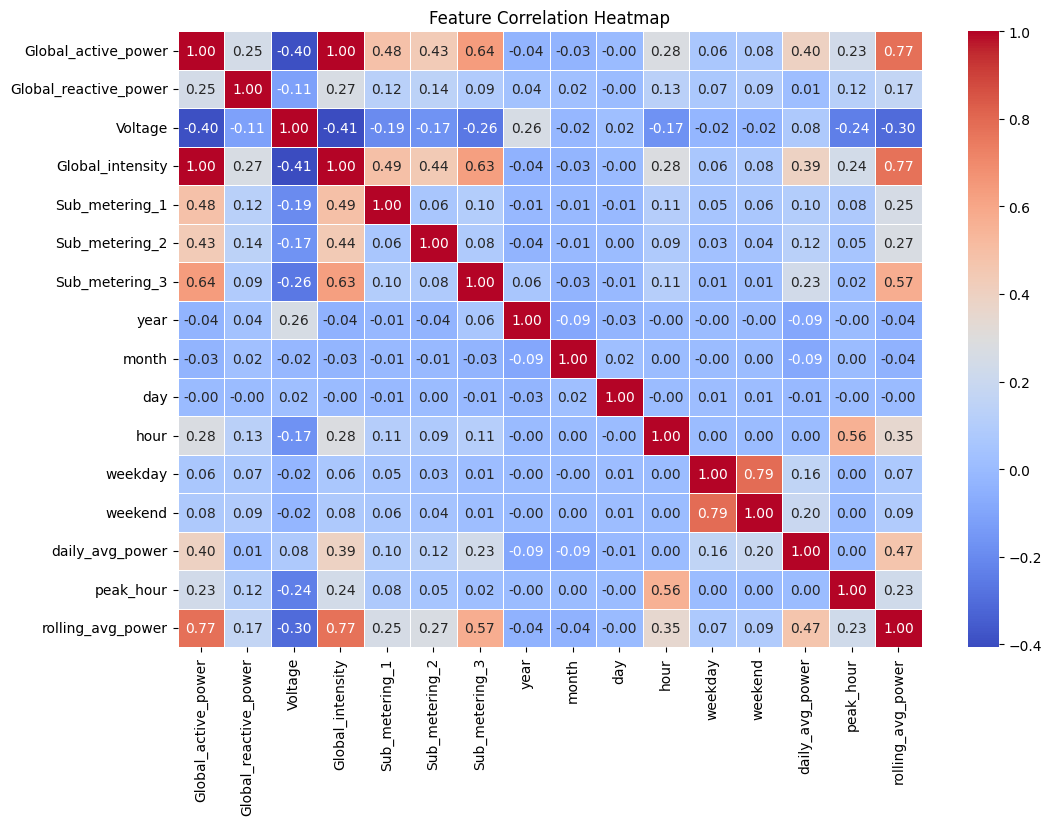

In [73]:
# Correlation heatmap to identify key influencing factors
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


# Define target variable and features

In [78]:
x = df[["Global_intensity",'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3' ,'Voltage']]
y = df["Global_active_power"]

In [79]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=30)

In [80]:
# Normalize features for neural networks only
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Linear Regression Model

In [81]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(x_test)

#evaluating the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae = mean_absolute_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression Model Evaluation:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-Squared (R²): {r2:.4f}")

Linear Regression Model Evaluation:
Root Mean Squared Error (RMSE): 0.0444
Mean Absolute Error (MAE): 0.0295
R-Squared (R²): 0.9982


# RandomForestRegressor

In [82]:
# RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=20,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=30
)

# Train the model
rf_model.fit(x_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(x_test)

#evaluating the random forest model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Model Evaluation:")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"R-Squared (R²): {r2_rf:.4f}")


Random Forest Model Evaluation:
Root Mean Squared Error (RMSE): 0.0597
Mean Absolute Error (MAE): 0.0399
R-Squared (R²): 0.9968


# GradientBoostingRegressor

In [83]:

gb_model = GradientBoostingRegressor(
    n_estimators=50,              # Reduced number of trees
    learning_rate=0.2,            # Increased learning rate
    max_depth=3,                  # Limited tree depth
    subsample=0.8,                # Use 80% of the data for each tree
    random_state=30
)

# Train the model
gb_model.fit(x_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(x_test)

#evaluating the GradientBoostingRegressor
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("\nGradientBoostingRegressor Model Evaluation:")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"R-Squared (R²): {r2_rf:.4f}")


GradientBoostingRegressor Model Evaluation:
Root Mean Squared Error (RMSE): 0.0597
Mean Absolute Error (MAE): 0.0399
R-Squared (R²): 0.9968


# MLPRegressor model

In [84]:
# Create the MLPRegressor model
nn_model = MLPRegressor(
    hidden_layer_sizes=(100,),  # Single hidden layer with 100 neurons
    activation='relu',          # Activation function
    solver='adam',              # Solver for weight optimization
    max_iter=100,
    warm_start=True, # Maximum number of iterations
    random_state=30
)

# Train the model
nn_model.fit(x_train_scaled, y_train)

# Predictions
y_pred_nn = nn_model.predict(x_test_scaled)

# Evaluating the MLPRegressor
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print("\nMLPRegressor (Neural Network) Model Evaluation:")
print(f"Root Mean Squared Error (RMSE): {rmse_nn:.4f}")
print(f"Mean Absolute Error (MAE): {mae_nn:.4f}")
print(f"R-Squared (R²): {r2_nn:.4f}")


MLPRegressor (Neural Network) Model Evaluation:
Root Mean Squared Error (RMSE): 0.0355
Mean Absolute Error (MAE): 0.0229
R-Squared (R²): 0.9989


# performance_comparison

In [85]:
performance_comparison = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting", "Neural Network"],
    "RMSE": [rmse, rmse_rf, rmse_gb, rmse_nn],
    "MAE": [mae, mae_rf, mae_gb, mae_nn],
    "R²": [r2, r2_rf, r2_gb, r2_nn]
})

print("\nModel Performance Comparison:")
print(performance_comparison)

# Identify the best model based on RMSE
best_model_index = performance_comparison['RMSE'].idxmin()
best_model_name = performance_comparison.loc[best_model_index, 'Model']
best_model_rmse = performance_comparison.loc[best_model_index, 'RMSE']

print(f"\nThe best model based on RMSE is: {best_model_name} with an RMSE of {best_model_rmse:.4f}")


Model Performance Comparison:
               Model      RMSE       MAE        R²
0  Linear Regression  0.044377  0.029540  0.998219
1      Random Forest  0.059745  0.039927  0.996772
2  Gradient Boosting  0.040143  0.026330  0.998543
3     Neural Network  0.035468  0.022881  0.998862

The best model based on RMSE is: Neural Network with an RMSE of 0.0355


# Actual vs Predicted

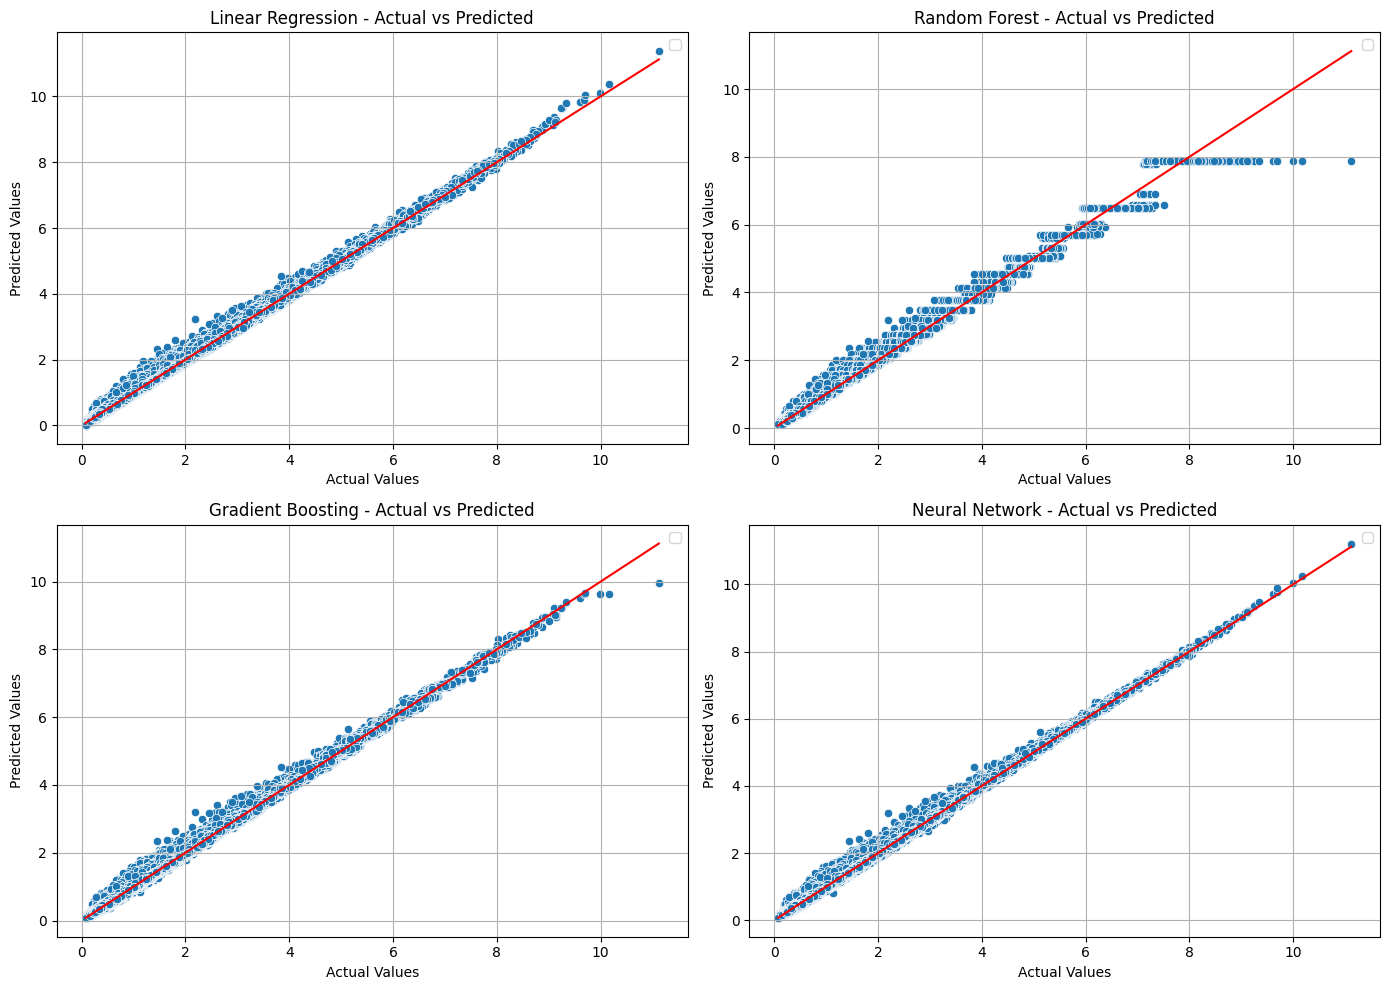

In [86]:
# Define the models and their respective predictions
models = {
    "Linear Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "Gradient Boosting": y_pred_gb,
    "Neural Network": y_pred_nn
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for ax, (model_name, y_pred) in zip(axes, models.items()):
    sns.scatterplot(x=y_test, y=y_pred, ax=ax)
    sns.lineplot(x=[min(y_test), max(y_test)], y=[min(y_test), max(y_test)], color='red', ax=ax)
    ax.set_title(f"{model_name} - Actual vs Predicted")
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.legend()
    ax.grid(True)


plt.tight_layout()
plt.show()


Distribution Plot
A distribution plot compares the distribution of actual vs. predicted values, helping to visualize how well the model captures the overall distribution of the data.

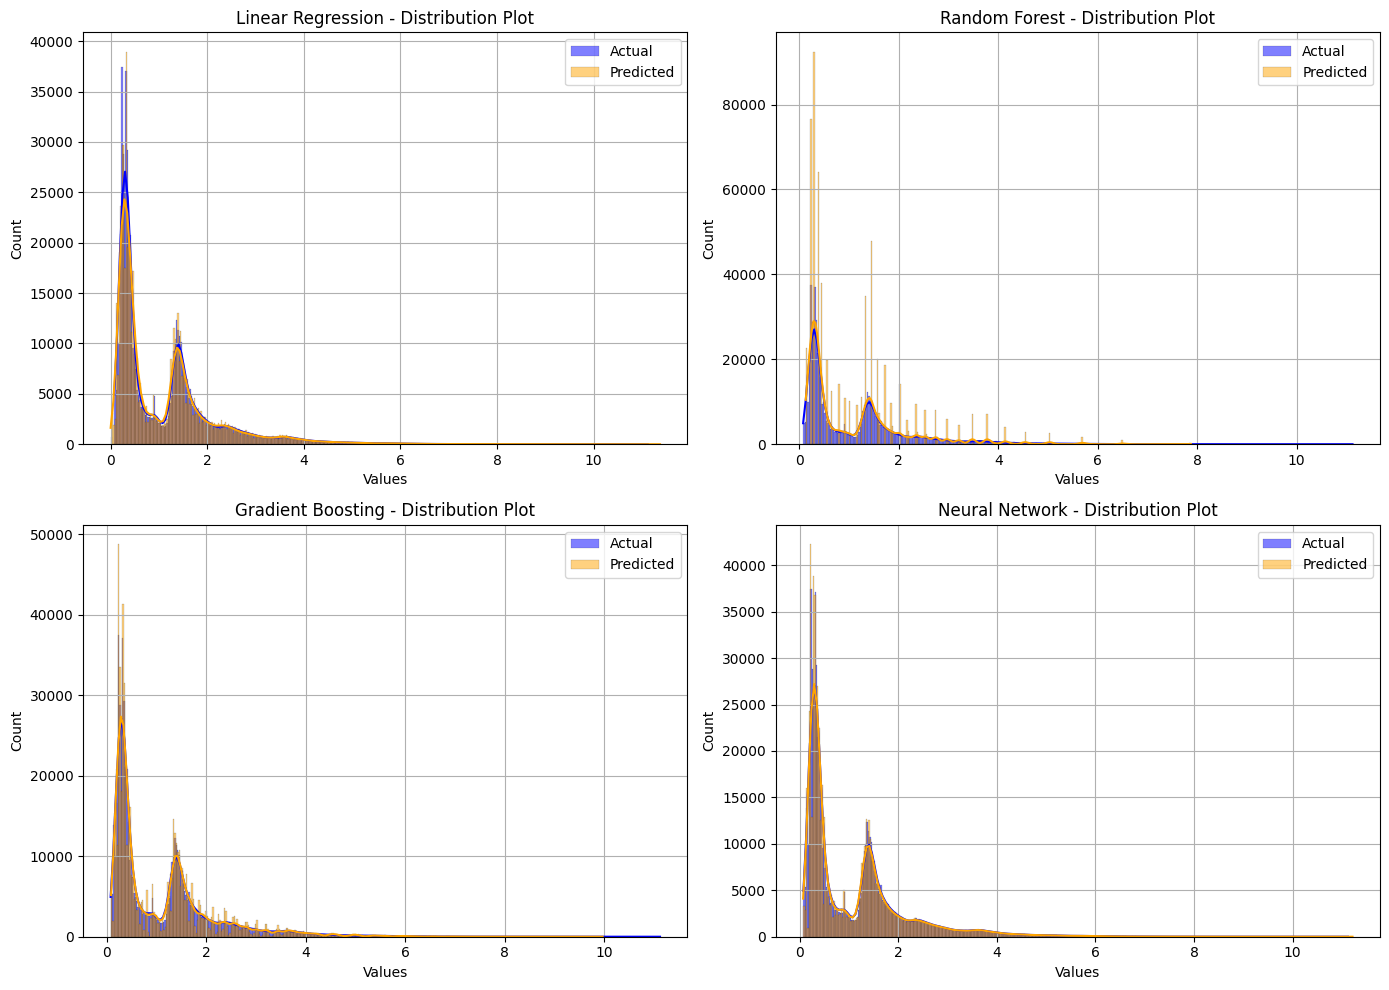

In [87]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for ax, (model_name, y_pred) in zip(axes, models.items()):
    sns.histplot(y_test, kde=True, label='Actual', color='blue', ax=ax)
    sns.histplot(y_pred, kde=True, label='Predicted', color='orange', ax=ax)
    ax.set_title(f"{model_name} - Distribution Plot")
    ax.set_xlabel("Values")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
